`tf.data`加载图片

先使用`tf.keras.preprocessing`加载磁盘文件目录

In [45]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import os
import PIL
import PIL.Image

In [46]:
import pathlib

data_file = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_file)

print(data_dir)

/Users/jacky/.keras/datasets/flower_photos


flowers_photos/
    daisy/
    dandelion/
    roses/
    sunflowers/
    tulips/

In [47]:
count = len(list(data_dir.glob('*/*.jpg')))

print(count)

3670


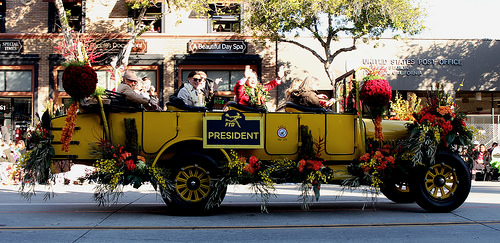

In [48]:
roses = list(data_dir.glob('roses/*'))

PIL.Image.open(roses[0])

使用 `tf.keras.preprocessing.image_dataset_from_directory` 函数加载图片(dir)。(即创建dataset)

In [49]:
batch_size = 32
img_height = 180
img_width = 180

# 1. 创建 dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [50]:
class_names = train_ds.class_names

print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


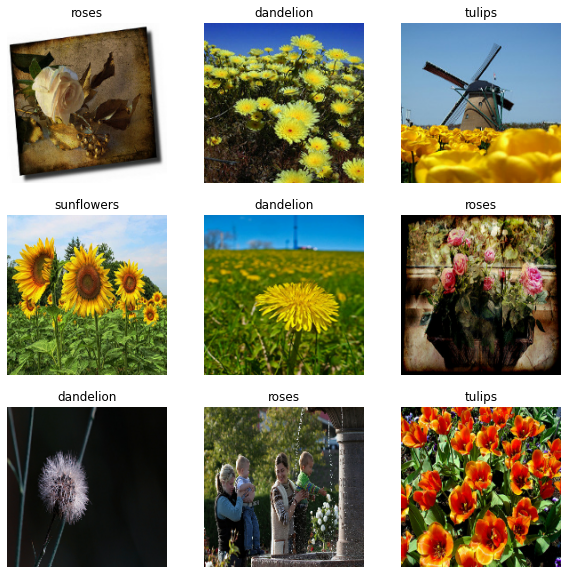

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# take 1 batch_ds = 32 photos
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # 不是图像矩阵了
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [52]:
for image_batch, labels_batch in train_ds:
    # (32, 180, 180, 3) 32张/batch, 180*180, dimension 3 for RGB
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


2. 标准化(归一化)数据

In [53]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

配置数据集以提高性能。

使用 `.cache()` 方法预加载数据。
使用 `.prefetch()` 在训练时重叠数据预处理和模型执行。

In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
num_classes = 5

# todo
# 图像shape数据表示：(num, 28, 28, 3) 图片数量, 28*28矩阵, (28*28)*3(RGB)的矩阵
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255),

    # todo batch_size:32
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    # 卷积后使用平均或者最大池化层都行
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    # 经过最后一层激活函数前平铺矩阵数据
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # 输出单元。参数：输出的结果数目(即总类别数量)
    tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=3)

Epoch 1/3


2021-08-22 00:27:52.935978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.2856 - accuracy: 0.4366 

2021-08-22 00:28:01.985183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 11s 109ms/step - loss: 1.2856 - accuracy: 0.4366 - val_loss: 1.0785 - val_accuracy: 0.5736
Epoch 2/3
92/92 [==============================] - 9s 99ms/step - loss: 0.9915 - accuracy: 0.6097 - val_loss: 0.9718 - val_accuracy: 0.6008

In [57]:
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
# 乱序
list_ds = list_ds.shuffle(count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
    print(f)

tf.Tensor(b'/Users/jacky/.keras/datasets/flower_photos/daisy/6208851904_9d916ebb32_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/jacky/.keras/datasets/flower_photos/dandelion/21523597492_39b6765cd7_m.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/jacky/.keras/datasets/flower_photos/daisy/153210866_03cc9f2f36.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/jacky/.keras/datasets/flower_photos/roses/12395698413_c0388278f7.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/jacky/.keras/datasets/flower_photos/daisy/301964511_fab84ea1c1.jpg', shape=(), dtype=string)


In [58]:
# 'ShuffleDataset' object has no attribute 'class_names'
# item.name: 最后一级的目录名称
class_names = [item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']
class_names = np.array(sorted(class_names))

print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [59]:
# 手动划分训练集、验证集
val_size = int(count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [60]:
# 把dataset格式转换成(img, label)格式

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)


def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [61]:
# 更新 dataset
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [62]:
for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [63]:
# todo 优化数据集
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

2021-08-22 00:28:22.116893: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


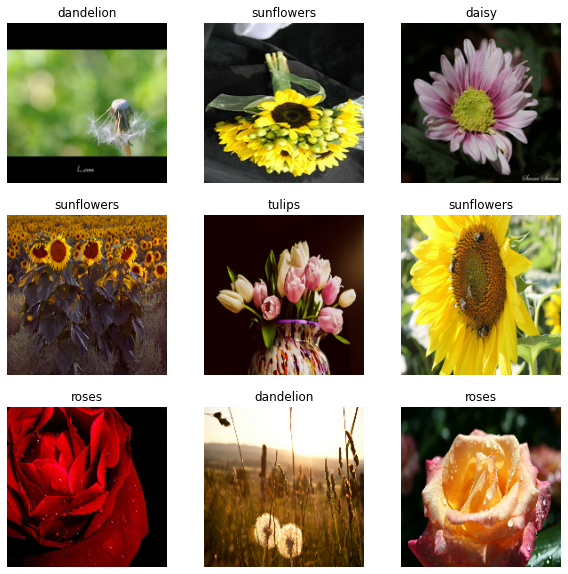

In [64]:
image_batch, label_batch = next(iter(train_ds))

# 画图
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

In [65]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


2021-08-22 02:40:25.686989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.7190  

2021-08-22 02:40:35.135896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 11s 113ms/step - loss: 0.7416 - accuracy: 0.7190 - val_loss: 0.6766 - val_accuracy: 0.7493
Epoch 2/3
92/92 [==============================] - 9s 94ms/step - loss: 0.5542 - accuracy: 0.7973 - val_loss: 0.7490 - val_accuracy: 0.7057

#### 使用 TFDS 数据集

In [66]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2021-08-22 02:45:52.028099: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2021-08-22 02:46:53.074152: E tensorflow/core/platform/cloud/curl_http_request.cc:614] The transmission  of request 0x2a23cf320 (URI: https://www.googleapis.com/storage/v1/b/tfds-data/o/dataset_info%2Ftf_flowers%2F3.0.1?fields=size%2Cgeneration%2Cupdated) has been stuck at 0 of 0 bytes for 61 seconds and will be aborted. CURL timing information: lookup time: 0.068318 (No error), connect time: 0 (No error), pre-transfer time: 0 (No error), start-transfer time: 0 (No error)
2021-08-22 02:47:54.248074: E tensorflow/core/platfor

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

ConnectionError: HTTPConnectionPool(host='download.tensorflow.org', port=80): Max retries exceeded with url: /example_images/flower_photos.tgz (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x2857de880>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))